### 1. Is it OK to initialize all the weights to the same value as long as that value is selected randomly using He initialization?

No, it is not OK to initialize all the weights to the same value, even if that value is selected randomly using He initialization. Initializing all weights to the same value would make the neurons symmetric, leading them to learn the same features and gradients, which in turn would prevent the network from learning effectively. It is essential to initialize weights with different values to break the symmetry and allow each neuron to learn different features.

### 2. Is it OK to initialize the bias terms to 0?

Yes, it is generally OK to initialize the bias terms to 0. Unlike weights, biases do not need to break symmetry because they are added after the weights are applied, and their primary role is to shift the activation function. Therefore, initializing biases to 0 is a common practice.

### 3. Name three advantages of the SELU activation function over ReLU.

1. **Self-Normalizing:** SELU activation functions tend to push the activations towards zero mean and unit variance, which helps maintain a self-normalizing property throughout the network. This can lead to faster convergence and more stable training.

2. **Internal Covariate Shift Reduction:** By maintaining zero mean and unit variance, SELU helps in reducing the internal covariate shift, which can further improve the training efficiency and convergence speed.

3. **No Dead Neurons:** Unlike ReLU, which can suffer from the dying ReLU problem where neurons can become inactive and never recover, SELU ensures that neurons continue to learn and adapt throughout the training process.

### 4. In which cases would you want to use each of the following activation functions?

- **SELU:** 
  - When building deep neural networks with many layers, as it helps in maintaining the self-normalizing property, leading to more stable and faster training.
  - Particularly useful in fully connected deep neural networks.

- **Leaky ReLU (and its variants):**
  - When dealing with the dying ReLU problem, where some neurons become inactive. Leaky ReLU allows a small gradient when the unit is not active.
  - Variants like Parametric ReLU (PReLU) can be useful when the model can learn the optimal slope of the negative part.

- **ReLU:**
  - When training deep neural networks where speed and simplicity are essential.
  - Commonly used in convolutional neural networks (CNNs) due to its efficiency and effectiveness in practice.

- **Tanh:**
  - When the data is centered around zero, as tanh outputs values between -1 and 1, making it useful for dealing with negative input values.
  - Can be preferred over logistic sigmoid in some cases due to its zero-centered output.

- **Logistic (Sigmoid):**
  - When dealing with binary classification problems, especially in the output layer where probabilities are required.
  - Useful for models that require a probabilistic interpretation of the output.

- **Softmax:**
  - In the output layer of neural networks for multi-class classification problems.
  - Converts the logits into probabilities, ensuring that the sum of the probabilities equals 1.

### 5. What may happen if you set the momentum hyperparameter too close to 1 (e.g., 0.99999) when using an SGD optimizer?

If the momentum hyperparameter is set too close to 1 (e.g., 0.99999), the updates may become too aggressive and oscillate around the minima, making it difficult for the optimizer to converge. This can lead to unstable training and may cause the optimizer to overshoot the optimal point repeatedly. It is important to find a balance where momentum helps accelerate convergence without causing excessive oscillations.

### 6. Name three ways you can produce a sparse model.

1. **L1 Regularization (Lasso):** Adding an L1 regularization term to the loss function encourages the model to produce weights that are exactly zero, leading to a sparse model.

2. **Pruning:** Removing weights or neurons with the smallest magnitudes after training can produce a sparse model. This can be done gradually during or after the training process.

3. **Sparse Initialization:** Starting with a sparse initialization of the weights, where most weights are set to zero, and only a few are non-zero. This can be particularly useful in certain types of models like sparse autoencoders.

### 7. Does dropout slow down training? Does it slow down inference (i.e., making predictions on new instances)? What about MC Dropout?

- **Dropout and Training:**
  - Dropout does slow down training because each training iteration involves randomly dropping units, which adds computational overhead. Additionally, the effective learning rate is reduced as the model needs to learn with fewer active neurons in each iteration.

- **Dropout and Inference:**
  - Dropout does not slow down inference because it is typically turned off during the prediction phase. During inference, the full network is used, and the weights are scaled to account for the dropped units during training.

- **MC Dropout:**
  - Monte Carlo (MC) Dropout does slow down inference because it involves performing multiple forward passes with dropout enabled to estimate uncertainty. This requires significantly more computation compared to a single forward pass without dropout.



### 8. Practice training a deep neural network on the CIFAR10 image dataset:

#### a. Build a DNN with 20 hidden layers of 100 neurons each (that’s too many, but it’s the point of this exercise). Use He initialization and the ELU activation function

In [39]:
# 1. Import Libraries:

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, ELU
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.utils import to_categorical


In [6]:
np.random.seed(42)

In [2]:
# 2. Load and Preprocess the Data:


#Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 113s 1us/step


In [4]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 10), (10000, 10))

In [7]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [21]:
def show_random_images(n, a=None, b=None, figsize=(15, 15), x_train = x_train, y_train = y_train):
    indices = np.random.choice(np.arange(x_train.shape[0]), n, replace=False)
    images = x_train[indices]
    labels = y_train[indices]

    if a is None or b is None:
        # Calculate a and b based on n
        a = int(np.ceil(np.sqrt(n)))
        b = int(np.ceil(n / a))
    
    plt.figure(figsize=figsize)
    for i in range(n):
        plt.subplot(a, b, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(class_names[np.argmax(labels[i])])
    plt.show()


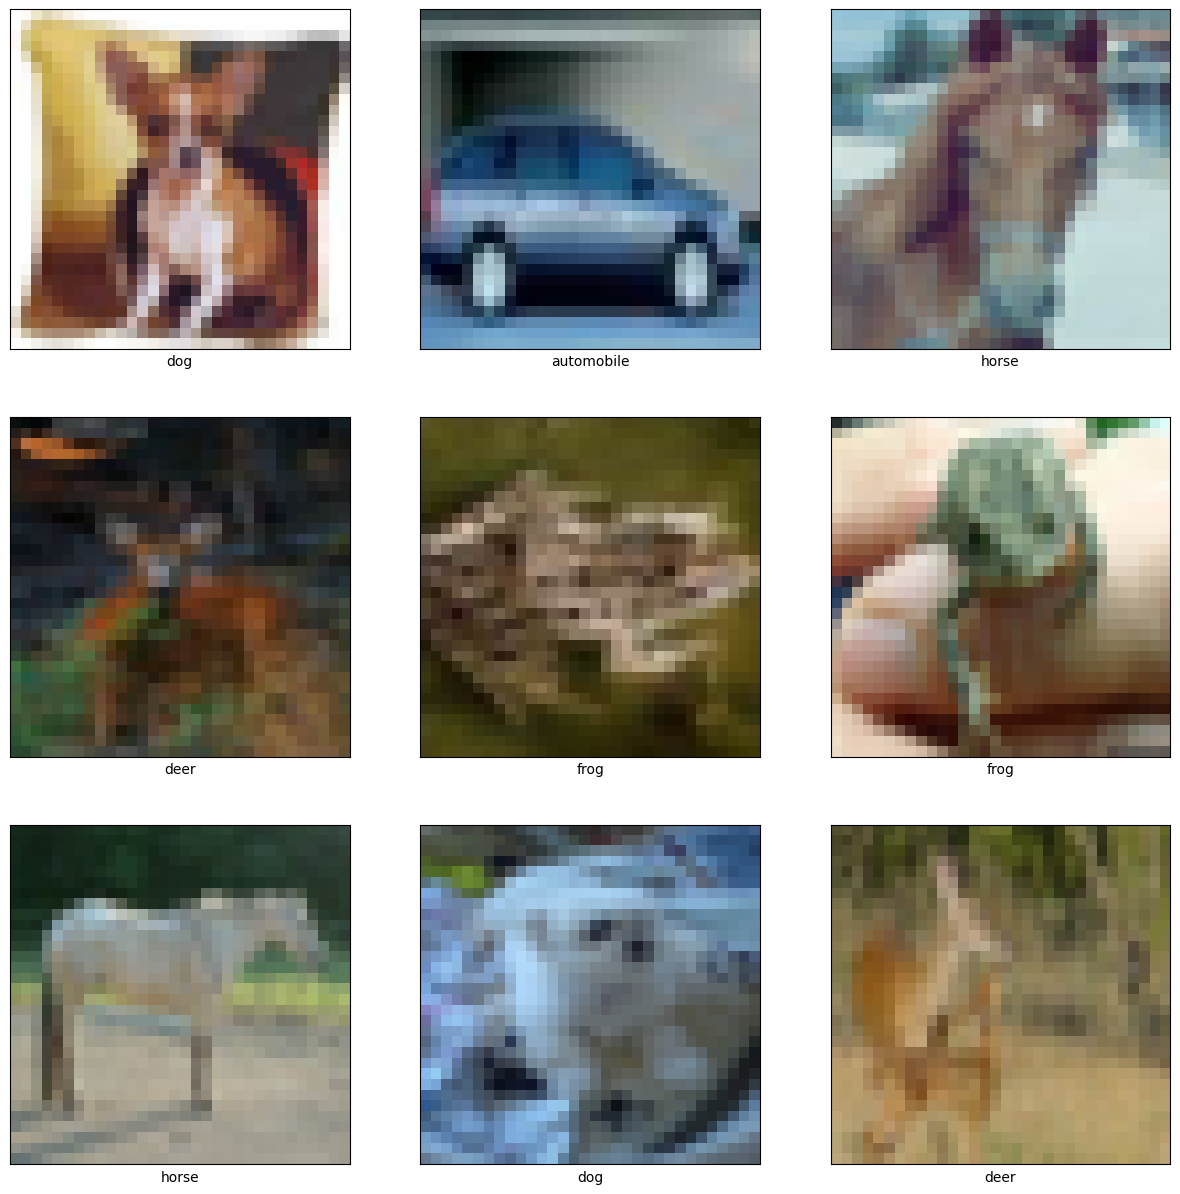

In [24]:
# Example usage
show_random_images(9)

In [25]:
# Function to create directory for storing models and training data
def get_chapter_directory(chapter_num):
    dir_name = f'chapter_{chapter_num}'
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

In [26]:
# Create chapter directory
chapter_dir = get_chapter_directory(11)

In [34]:
# 3. Build the Model:

checkpoint_path = os.path.join(chapter_dir, "cifar10_dnn.weights.h5")
tensorboard_log_dir = os.path.join(chapter_dir, "logs")

# Create callbacks
checkpoint_cb = ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1)
tensorboard_cb = TensorBoard(log_dir=tensorboard_log_dir, histogram_freq=1)
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Define the model
model = Sequential()

# Flatten the input images
model.add(Flatten(input_shape=(32, 32, 3)))

# Add 20 hidden layers with 100 neurons each, He initialization, and ELU activation
for _ in range(20):
    model.add(Dense(100, kernel_initializer=HeNormal(), activation='elu'))

# Output layer with 10 neurons (one for each class), using softmax activation
model.add(Dense(10, activation='softmax'))

/home/im-ik/miniconda3/envs/handson-ml2/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [40]:
# 4. Compile the model

# Compile the model with SGD optimizer
model.compile(optimizer=Nadam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [41]:
# Train the model with callbacks
history = model.fit(x_train, y_train,
                    epochs=60,
                    batch_size=32,
                    validation_split=.2,
                    callbacks=[checkpoint_cb, tensorboard_cb, early_stopping_cb])